LaTeX macros (hidden cell)
$
\newcommand{\Q}{\mathcal{Q}}
\newcommand{\ECov}{\boldsymbol{\Sigma}}
\newcommand{\EMean}{\boldsymbol{\mu}}
\newcommand{\EAlpha}{\boldsymbol{\alpha}}
\newcommand{\EBeta}{\boldsymbol{\beta}}
$

# Imports and configuration

In [1]:
%%bash
FILE=/content/portfolio_tools.py
if [[ ! -f $FILE ]]; then
    wget https://raw.githubusercontent.com/MOSEK/PortfolioOptimization/main/python/notebooks/portfolio_tools.py
fi

--2025-03-15 11:45:25--  https://raw.githubusercontent.com/MOSEK/PortfolioOptimization/main/python/notebooks/portfolio_tools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7292 (7.1K) [text/plain]
Saving to: ‘portfolio_tools.py’

     0K .......                                               100% 54.8M=0s

2025-03-15 11:45:25 (54.8 MB/s) - ‘portfolio_tools.py’ saved [7292/7292]



In [2]:
%pip install mosek
%env PYTHONPATH /env/python:/content
from google.colab import drive
drive.mount('/content/gdrive')
%env MOSEKLM_LICENSE_FILE /content/gdrive/My Drive/mosek/mosek.lic

# To execute the notebook directly in colab make sure your MOSEK license file is in one the locations
#
# /content/mosek.lic   or   /root/mosek/mosek.lic
#
# inside this notebook's internal filesystem.
#
# You will also need an API key from a stock data provider, or ready data files in a "stock_data" folder.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 24.4 MB/s eta 0:00:00
env: PYTHONPATH=/env/python:/content
Mounted at /content/gdrive
env: MOSEKLM_LICENSE_FILE=/content/gdrive/My Drive/mosek/mosek.lic


In [3]:
import sys
import os
import re
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from mosek.fusion import *
import mosek.fusion.pythonic          # From MOSEK >= 10.2

from notebook.services.config import ConfigManager

# portfolio_tools.py is a Mosek helper file distributed together with the notebooks
from portfolio_tools import data_download, DataReader, compute_inputs

In [4]:
# Version checks
print(sys.version)
print('matplotlib: {}'.format(matplotlib.__version__))

# Jupyter configuration
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

# Numpy options
np.set_printoptions(precision=5, linewidth=120, suppress=True)

# Pandas options
pd.set_option('display.max_rows', None)

# Matplotlib options
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
matplotlib: 3.10.0


In [76]:
#URL = r"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={ticker}&apikey={token}&outputsize=full&datatype=csv"
import requests
ticker = "MSFT"
token = "BVOOFLW8I15YY2H8"
URL = r"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={ticker}&interval=5min&apikey={token}&outputsize=full&datatype=csv"
url = URL.format(ticker=ticker, token=token)
result = requests.get(url, allow_redirects=True)

In [77]:
fname = "IBM.csv"
with open(fname, 'wb') as f:
    f.write(result.content)

In [78]:
df = pd.read_csv(fname)

In [79]:
df['date'] = pd.to_datetime(df['timestamp']).dt.date
df['time'] = pd.to_datetime(df['timestamp']).dt.time

In [80]:
df.tail()

,timestamp,open,high,low,close,volume,date,time
3982,2025-02-13 04:20:00,407.0681,407.1878,406.8385,406.8984,4964,2025-02-13,04:20:00
3983,2025-02-13 04:15:00,406.9383,407.0681,406.8585,406.9882,1542,2025-02-13,04:15:00
3984,2025-02-13 04:10:00,406.8385,406.9583,406.7188,406.9483,1823,2025-02-13,04:10:00
3985,2025-02-13 04:05:00,406.8785,406.9982,406.6888,406.8485,964,2025-02-13,04:05:00
3986,2025-02-13 04:00:00,407.8864,409.1639,406.4593,406.8884,4328,2025-02-13,04:00:00


In [89]:
df['move'] = (df['high'] - df['low']) * 1e4/ df['low']

In [81]:
ll = df[['date','time','volume']].set_index(['date','time']).groupby(level=['date','time']).sum() / df[['date','time','volume']].set_index(['date','time']).groupby(level=0).sum()
final = ll.groupby(level=0).cumsum()

In [82]:
final2 = ll.groupby(level=1).mean().cumsum()

<Axes: xlabel='time'>

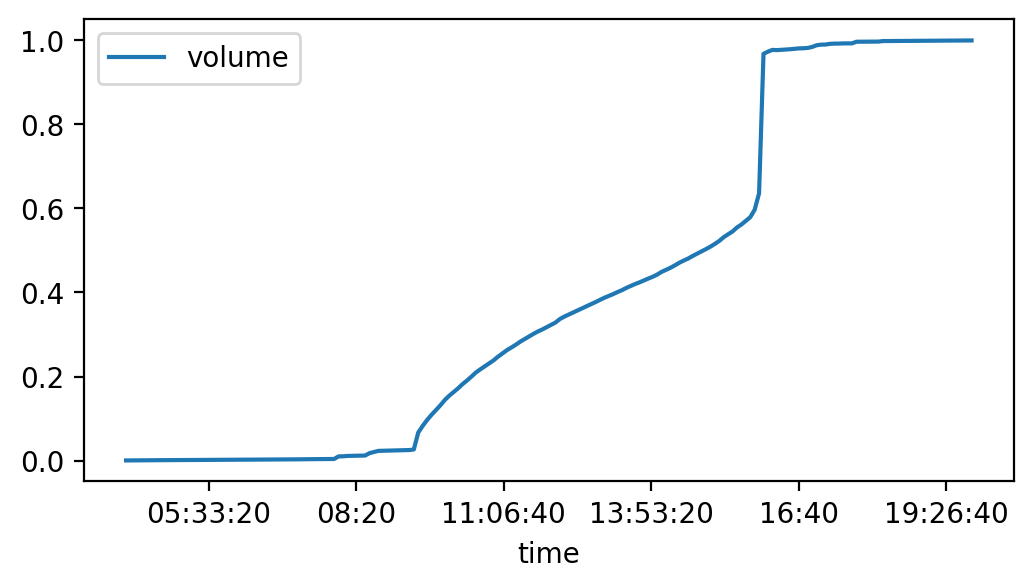

In [83]:
final.reset_index()[['time','volume']].groupby(['time']).mean().plot(figsize=(6,3))

<Axes: xlabel='time'>

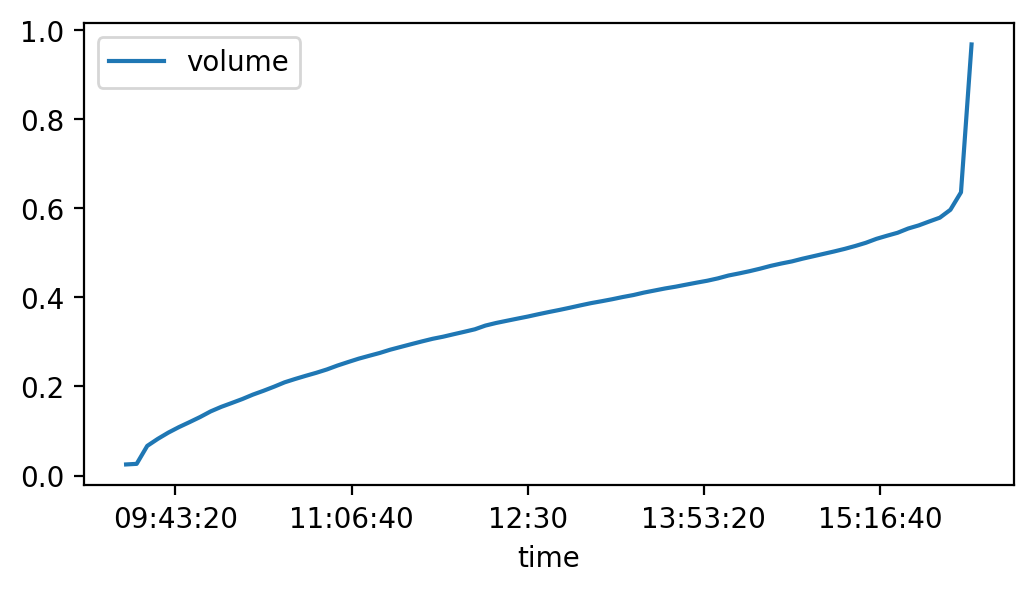

In [87]:
final.reset_index()[['time','volume']].groupby(['time']).mean()[64:-47].plot(figsize=(6,3))

<Axes: title={'center': 'MSFT normalized volume intraday (1 month period, 5 min interval) '}, xlabel='time'>

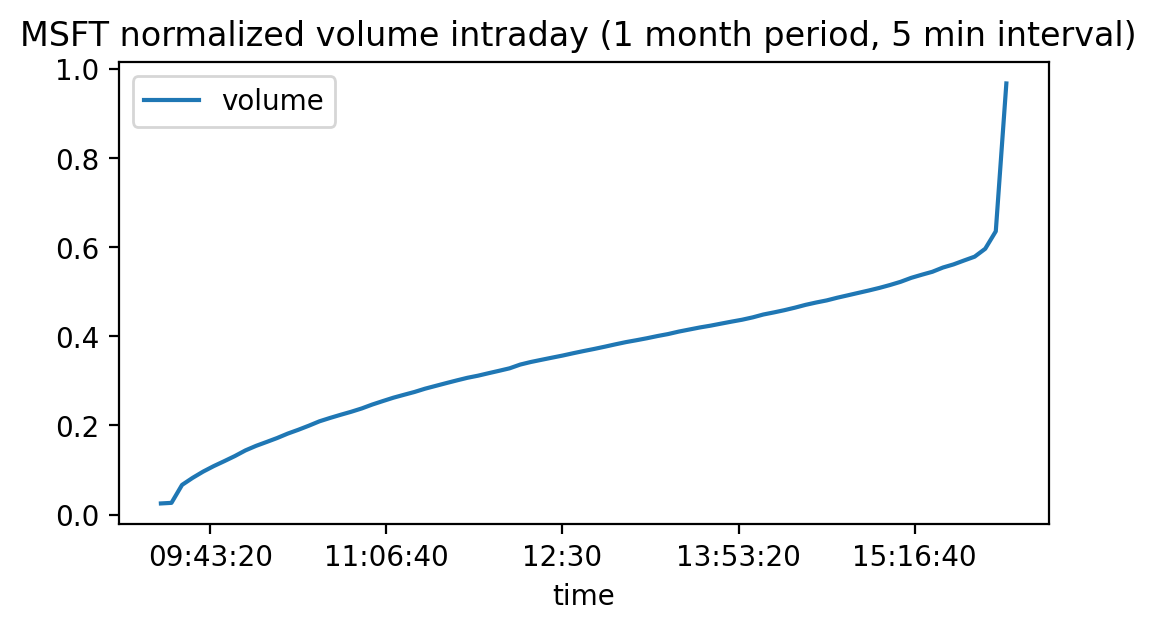

In [91]:
final2.reset_index()[['time','volume']].groupby(['time']).mean()[64:-47].plot(figsize=(6,3),title='MSFT normalized volume intraday (1 month period, 5 min interval) ')

<Axes: title={'center': 'MSFT high-low move in bps intraday (1 month period, 5 min interval) '}, xlabel='time'>

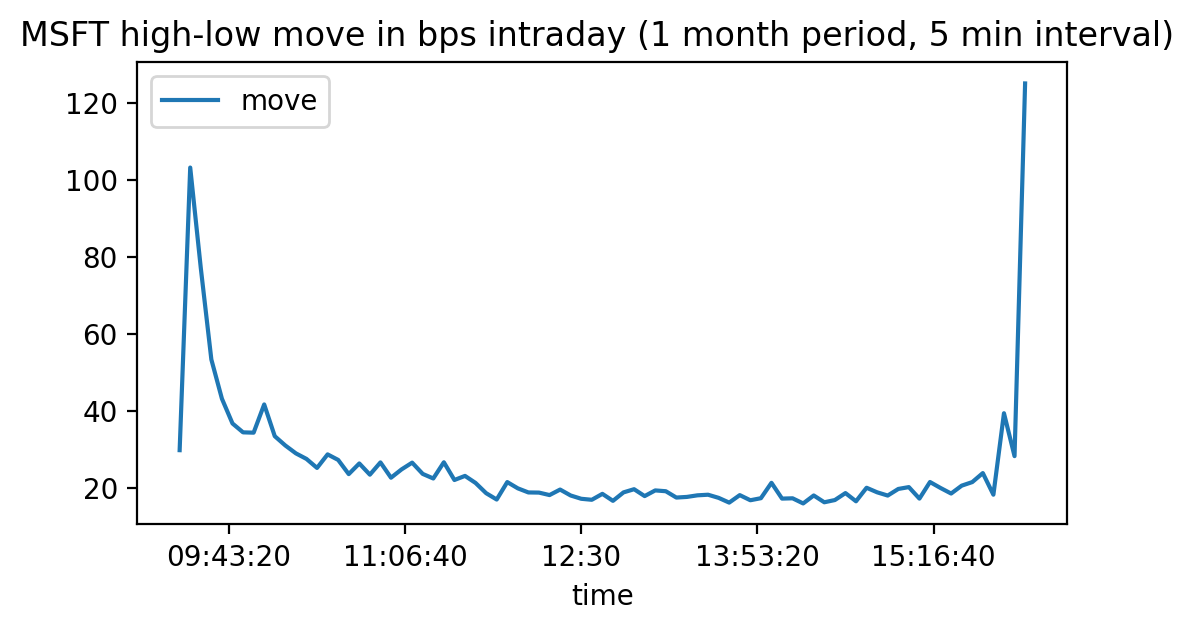

In [97]:
pp = df[['time','move']].set_index(['time']).groupby(level=['time']).mean()
pp[64:-47].plot(figsize=(6,3),title='MSFT high-low move in bps intraday (1 month period, 5 min interval) ')


In [95]:
pp

,volume
time,
04:00:00,5.776333e+03
04:05:00,3.364571e+03
04:10:00,2.626905e+03
04:15:00,2.336857e+03
04:20:00,2.786524e+03
04:25:00,1.792714e+03
04:30:00,2.262524e+03
04:35:00,1.462619e+03
04:40:00,1.667381e+03


In [36]:
df.iloc[::-1].set_index('timestamp')[['volume']].cumsum()[:-20]

,volume
timestamp,
2025-02-13 04:00:00,3
2025-02-13 04:05:00,6
2025-02-13 04:10:00,7
2025-02-13 04:15:00,11
2025-02-13 04:20:00,126
2025-02-13 04:25:00,127
2025-02-13 04:35:00,132
2025-02-13 04:40:00,156
2025-02-13 04:45:00,219


<Axes: xlabel='timestamp'>

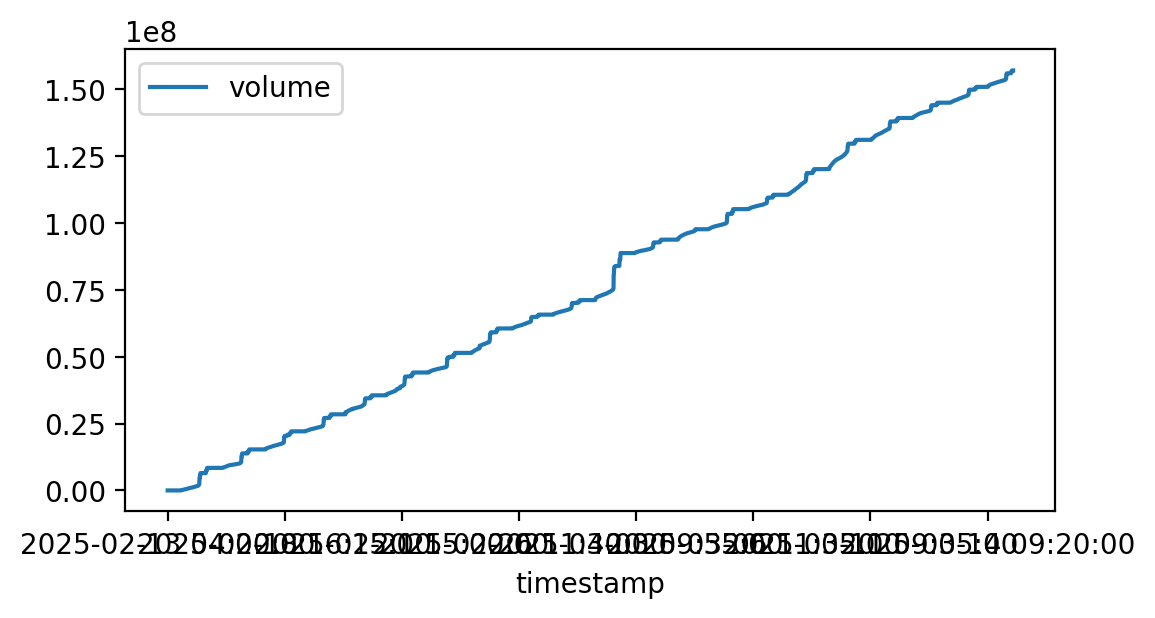

In [33]:
df.iloc[::-1].set_index('timestamp')[['volume']].cumsum().plot(figsize=(6,3))

# Prepare input data

Here we load the raw data that will be used to compute the optimization input variables, the vector $\EMean$ of expected returns and the covariance matrix $\ECov$. The data consists of daily stock prices of $8$ stocks from the US market.

## Download data

In [ ]:
# Data downloading:
# If the user has an API key for alphavantage.co, then this code part will download the data.
# The code can be modified to download from other sources. To be able to run the examples,
# and reproduce results in the cookbook, the files have to have the following format and content:
# - File name pattern: "daily_adjusted_[TICKER].csv", where TICKER is the symbol of a stock.
# - The file contains at least columns "timestamp", "adjusted_close", and "volume".
# - The data is daily price/volume, covering at least the period from 2016-03-18 until 2021-03-18,
# - Files are for the stocks PM, LMT, MCD, MMM, AAPL, MSFT, TXN, CSCO.
list_stocks = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
list_factors = []
alphaToken = None

list_tickers = list_stocks + list_factors
if alphaToken is not None:
    data_download(list_tickers, alphaToken)

## Read data

We load the daily stock price data from the downloaded CSV files. The data is adjusted for splits and dividends. Then a selected time period is taken from the data.

In [ ]:
investment_start = "2016-03-18"
investment_end = "2021-03-18"

In [ ]:
# The files are in "stock_data" folder, named as "daily_adjusted_[TICKER].csv"
dr = DataReader(folder_path="stock_data", symbol_list=list_tickers)
dr.read_data(read_volume=True)
df_prices, df_volumes = dr.get_period(start_date=investment_start, end_date=investment_end)

# Run the optimization

## Define the optimization model

Below we implement the optimization model in Fusion API. We create it inside a function so we can call it later.

The parameters:
- `vp`/`vm`: Variable cost coefficients,
- `fp`/`fm`: Fixed cost coefficients,
- `up`/`um`: Upper bound of long and short side of the portfolio,
- `lp`/`lm`: Lower bound of long and short side of the portfolio,
- `pcoef`: Penalty term coefficient. (We use a penalty term to force either `xp` or `xm` to zero.)

In [ ]:
# x = xp - xm
# NOTE: Uses integer variables!
def posneg(M, x, bigm_p, bigm_m=None):
    bigm_m = bigm_p if bigm_m is None else bigm_m

    # Positive and negative part of x
    xp = M.variable("_xp", N, Domain.greaterThan(0.0))
    xm = M.variable("_xm", N, Domain.greaterThan(0.0))

    # Binary variables
    yp = M.variable("_yp", N, Domain.binary())
    ym = M.variable("_ym", N, Domain.binary())

    # Constraint assigning xp and xm to be the positive and negative part of x.
    M.constraint('_pos-neg-part', x == xp - xm)

    # Constraints making sure xp and xm are never both positive.
    M.constraint('_ubound-p', xp <= bigm_p * yp)
    M.constraint('_ubound-m', xm <= bigm_m * ym)
    M.constraint('_exclusion', yp + ym <= 1.0)

    return xp, xm, yp, ym


def EfficientFrontier(N, m, G, deltas, vp, vm, fp, fm, up, um, lp, lm, pcoef):

    with Model("Case study") as M:
        # Settings
        #M.setLogHandler(sys.stdout)

        # Real variables
        # The variable x is the fraction of holdings in each security.
        x = M.variable("x", N, Domain.unbounded())

        # The variable s models the portfolio variance term in the objective.
        s = M.variable("s", 1, Domain.unbounded())

        # Auxiliary variable for 130/30 leverage constraint
        z = M.variable("z", N, Domain.unbounded())

        # Positive and negative part of x
        xp, xm, yp, ym = posneg(M, x, up, um)

        # Buy-in
        M.constraint('lbound-p', xp >= lp * yp)
        M.constraint('lbound-m', xm >= lm * ym)

        # Budget constraint with transaction cost terms
        fixcost_terms = yp.T @ fp + ym.T @ fm
        varcost_terms = xp.T @ vp + xm.T @ vm
        budget_terms = Expr.sum(x) + varcost_terms + fixcost_terms
        M.constraint('budget', budget_terms == 1.0)

        # 130/30 leverage constraint
        M.constraint('leverage-gt', z >= x)
        M.constraint('leverage-ls', z >= -x)
        M.constraint('leverage-sum', Expr.sum(z) + varcost_terms + fixcost_terms == 1.6)

        # Objective (quadratic utility version)
        delta = M.parameter()
        penalty = pcoef * Expr.sum(xp + xm)
        M.objective('obj', ObjectiveSense.Maximize, x.T @ m - penalty - delta * s)

        # Conic constraint for the portfolio variance
        M.constraint('risk', Expr.vstack(s, 1, G.T @ x), Domain.inRotatedQCone())

        columns = ["delta", "obj", "return", "risk", "x_sum", "tcost"] + df_prices.columns.tolist()
        df_result = pd.DataFrame(columns=columns)
        for idx, d in enumerate(deltas):
            # Update parameter
            delta.setValue(d);

            # Solve optimization
            M.solve()

            # Check if the solution is an optimal point
            solsta = M.getPrimalSolutionStatus()
            if (solsta != SolutionStatus.Optimal):
                # See https://docs.mosek.com/latest/pythonfusion/accessing-solution.html about handling solution statuses.
                raise Exception("Unexpected solution status!")

            # Save results
            portfolio_return = m @ x.level()
            portfolio_risk = np.sqrt(2 * s.level()[0])
            tcost = np.dot(vp, xp.level()) + np.dot(vm, xm.level()) + np.dot(fp, yp.level()) + np.dot(fm, ym.level())
            row = pd.Series([d, M.primalObjValue(), portfolio_return, portfolio_risk,
                             sum(x.level()), tcost] + list(x.level()), index=columns)
            df_result = pd.concat([df_result, pd.DataFrame([row])], ignore_index=True)

        return df_result

## Compute optimization input variables

Here we use the loaded daily price data to compute the corresponding yearly mean return and covariance matrix.

In [ ]:
# Number of securities
N = df_prices.shape[1]

# Get optimization parameters
m, S = compute_inputs(df_prices)

Next we compute the matrix $G$ such that $\ECov=GG^\mathsf{T}$, this is the input of the conic form of the optimization problem. Here we use Cholesky factorization.

In [ ]:
# Cholesky factor of S to use in conic risk constraint
G = np.linalg.cholesky(S)

## Call the optimizer function

We run the optimization for a range of risk aversion parameter values: $\delta = 10^{-0.5},\dots,10^{2}$. We compute and plot the efficient frontier this way both with and without transaction cost.

In [ ]:
deltas = np.logspace(start=-0.5, stop=2, num=20)[::-1]
ax = plt.gca()
for a in [0, 1]:
    pcoef = a * 0.03
    fp = a * 0.005 * np.ones(N) # Depends on portfolio value
    fm = a * 0.01 * np.ones(N) # Depends on portfolio value
    vp = a * 0.01 * np.ones(N)
    vm = a * 0.02 * np.ones(N)
    up = 2.0
    um = 2.0
    lp = a * 0.05
    lm = a * 0.05

    df_result = EfficientFrontier(N, m, G, deltas, vp, vm, fp, fm, up, um, lp, lm, pcoef)
    df_result.plot(ax=ax, x="risk", y="return", style="-o",
                   xlabel="portfolio risk (std. dev.)", ylabel="portfolio return", grid=True)
ax.legend(["return without transaction cost", "return with transaction cost"]);